In [1]:
from landlab import RasterModelGrid, HexModelGrid
from bmi_topography import Topography
from scipy.interpolate import LinearNDInterpolator
from landlab.components import FlowAccumulator, ChannelProfiler, SinkFillerBarnes
from landlab.grid.create_network import network_grid_from_raster

import numpy as np
from matplotlib import pyplot as plt
from landlab.plot.graph import plot_graph

/Users/behiyenilayiscen/opt/anaconda3/envs/landlabnilay/lib/python3.11/site-packages/bmi_topography/api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


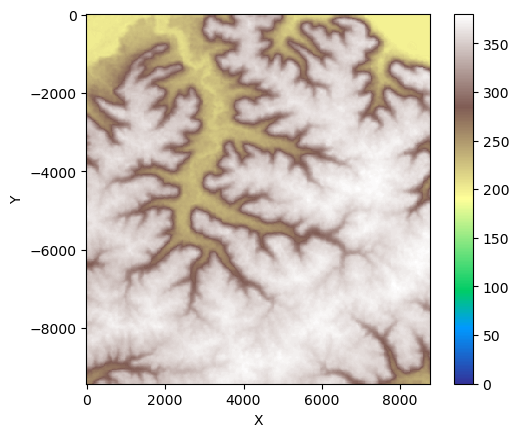

In [2]:
trout_dem = Topography(
    north=44.2,
    south=44.115,
    east=-91.857,
    west=-91.967,
    output_format="GTiff",
    dem_type="SRTMGL1",
)

trout = trout_dem.load()

z = trout.values.squeeze()
x_spacing = np.mean(np.diff(trout.x))*111000*np.cos(np.mean(trout.y)*np.pi/180.)
y_spacing = np.mean(np.diff(trout.y))*111000
grid = RasterModelGrid(z.shape, xy_spacing=(x_spacing, y_spacing))
grid.at_node["topographic__elevation"] = z

grid.imshow("topographic__elevation", cmap="terrain", vmin=0)
plt.savefig("L1.png")

In [3]:
# Make a hex grid
hex_dx = 50.
hg = HexModelGrid(( grid.number_of_cell_columns//2,
                          grid.number_of_cell_rows//2 ),
                          xy_of_lower_left=(0,-9500),
                          spacing=hex_dx,
                        node_layout="rect")

# Interpolate DEM values onto hex grid
interp = LinearNDInterpolator(grid.xy_of_node, grid.at_node["topographic__elevation"])
zhex = interp(hg.x_of_node, hg.y_of_node)
hg.at_node["topographic__elevation"] = zhex

In [4]:
# Run flow accumulator
flow = FlowAccumulator(hg, flow_director='FlowDirectorSteepest', depression_finder = 'DepressionFinderAndRouter')
flow.run_one_step()

# Run channel profiler
area_threshold = 500000

profiler = ChannelProfiler(hg,number_of_watersheds=1,minimum_channel_threshold=area_threshold,main_channel_only=False)
profiler.run_one_step()

# Cutting out the channel network
hg.add_zeros('watershed_mask',at='node')

outlet = list(profiler.data_structure.keys())[0]          #outlet from channel profiler
segments = list(profiler.data_structure[outlet].keys())   #segments for that watershed
for i, segment in enumerate(segments):                    #cycle thru segments
    ids = profiler.data_structure[outlet][segment]['ids']
    hg.at_node['watershed_mask'][ids] = 1.0


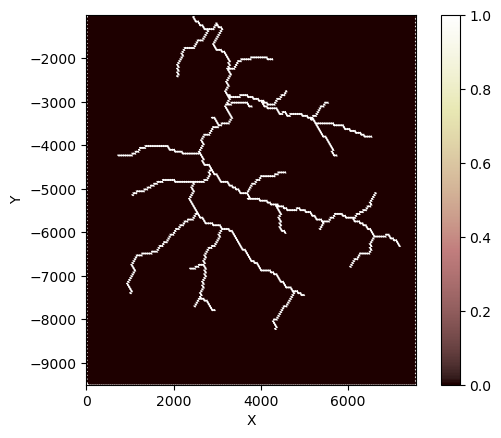

In [5]:
plt.figure()
hg.imshow("watershed_mask", allow_colorbar=True)

hg.at_node['topographic__elevation'][hg.at_node['watershed_mask']==0.0] = np.nan
hg.status_at_node[hg.at_node['watershed_mask']==0.0] = 4
hg.status_at_node[outlet] = 1

sfb = SinkFillerBarnes(hg, method='Steepest',fill_flat=False, ignore_overfill=True)
sfb.run_one_step()

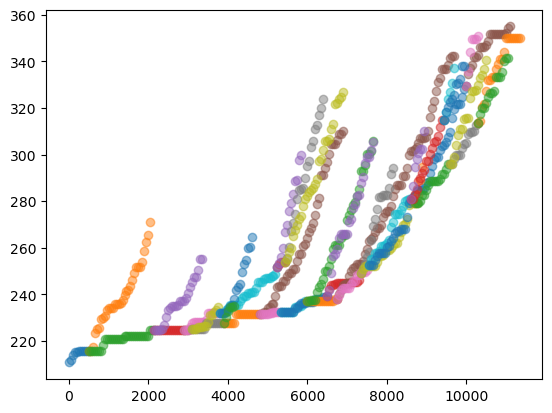

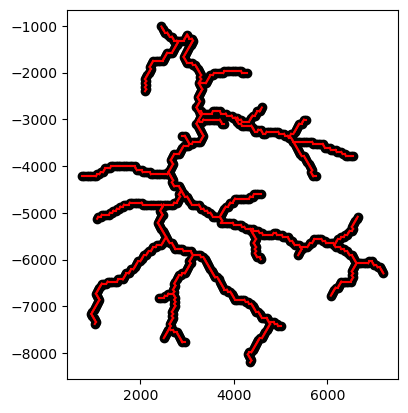

In [6]:
# Plot channel profiles
plt.figure(3)
outlets = list(profiler.data_structure.keys()) #outlets from channel profiler
for outlet in outlets: #cycle thru outlets
    segments = list(profiler.data_structure[outlet].keys()) #segments for that watershed
    #print(segments)
    for i, segment in enumerate(segments): #cycle thru segments
        ids = profiler.data_structure[outlet][segment]['ids'] #ids (index) of each segment
        distance = profiler.data_structure[outlet][segment]['distances']#distance downstream of each segment node
        eta = hg.at_node['topographic__elevation'][ids] #elevation of each segment node
        plt.scatter(distance,eta,alpha=0.5) #plot profile   
        
# Make raster grid into network grid
network_grid = network_grid_from_raster(hg,minimum_channel_threshold=area_threshold,include=["drainage_area", "topographic__elevation"])

# Plotting the network grid
plt.figure(4)

# Plot all nodes
plt.scatter(network_grid.x_of_node,network_grid.y_of_node,color='k')

#label nodes with elevation
# for i in range(0,network_grid.number_of_nodes):
#     plt.text(network_grid.x_of_node[i],network_grid.y_of_node[i],' n'+str(i)+',' +str(round(network_grid.at_node['topographic__elevation'][i])) ,va='center',ha='left')
    
# Plot the links
for i in range(0,network_grid.number_of_links):
    i1 = network_grid.nodes_at_link[i][0]
    i2 = network_grid.nodes_at_link[i][1]
    x1,y1 = network_grid.x_of_node[i1],network_grid.y_of_node[i1]
    x2,y2 = network_grid.x_of_node[i2],network_grid.y_of_node[i2]
    plt.plot([x1,x2],[y1,y2],color='r')
plt.gca().set_aspect('equal')
plt.show()

In [7]:
profiler.data_structure

# Initalize lists to hold data
upstream_segment_list = []
downstream_segment_list = []
distance_list = []
elevation_list = []

Qlist = []
pp = 25. /365.25/24./3600. #m/sec

# Run thru segments in the outlets
for outlet in outlets: #cycle thru outlets
    segments = list(profiler.data_structure[outlet].keys()) #segments for that watershed
    for i, segment_A in enumerate(segments): #cycle thru segments
        ids = profiler.data_structure[outlet][segment_A]['ids']
        distance_list += [profiler.data_structure[outlet][segment_A]['distances']] #distance downstream of each segment node]
        elevation_list += [hg.at_node['topographic__elevation'][ids]] #distance downstream of each segment node]
        
        #Q_list 
        Q = pp*hg.at_node['drainage_area'][ids[-1]]
        Qlist.append(Q)
        
        upstream_temp = []
        downstream_temp = []
        for j, segment_B in enumerate(segments): #cycle thru segments
            if segment_A[1] == segment_B[0]:
                upstream_temp += [j]
            if segment_A[0] == segment_B[1]:
                downstream_temp = [j]
                
        upstream_segment_list += [upstream_temp]
        downstream_segment_list += [downstream_temp]

# Hardcode Q
Q_trib = 5.0
Qlist_hard = np.zeros_like(Qlist)
for i, up in enumerate(upstream_segment_list):
    if up == []:
        Qlist_hard[i] = Q_trib
        down = downstream_segment_list[i]
        while down !=[]:
            Qlist_hard[down] += Q_trib
            down = downstream_segment_list[down[0]]
Qlist = Qlist_hard

print (Qlist)
print (upstream_segment_list)
print (downstream_segment_list)

[ 110.    5.  105.  100.    5.   80.   20.   75.    5.   15.    5.   70.
    5.   10.    5.    5.   65.    5.    5.   35.   30.   30.    5.   25.
    5.    5.   25.    5.   20.   15.   10.    5.   15.   10.    5.    5.
    5.   10.    5.    5.    5.    5.    5.]
[[1, 2], [], [3, 4], [5, 6], [], [7, 8], [9, 10], [11, 12], [], [13, 14], [], [15, 16], [], [17, 18], [], [], [19, 20], [], [], [21, 22], [23, 24], [25, 26], [], [27, 28], [], [], [29, 30], [], [31, 32], [33, 34], [35, 36], [], [37, 38], [39, 40], [], [], [], [41, 42], [], [], [], [], []]
[[], [0], [0], [2], [2], [3], [3], [5], [5], [6], [6], [7], [7], [9], [9], [11], [11], [13], [13], [16], [16], [19], [19], [20], [20], [21], [21], [23], [23], [26], [26], [28], [28], [29], [29], [30], [30], [32], [32], [33], [33], [37], [37]]


In [8]:
import numpy as np
from matplotlib import pyplot as plt
import grlp

try:
    from importlib import reload
except ImportError:
    pass
reload(grlp)

# Choose whether to draw plots interactively
#plt.ion()
plt.ioff()

S0 = 0.015
P_xB = 0.2
z1 = 0 

dt = 3.15E7 # time step

nseg = len(Qlist) # number of segments

segments = []
for i in range(nseg):
    segments.append(grlp.LongProfile())

grid_size = hex_dx
i = 0
switch = 0
for lp in segments:
    lp.set_ID(i)
    lp.set_upstream_segment_IDs(upstream_segment_list[i])
    lp.set_downstream_segment_IDs(downstream_segment_list[i])
    lp.set_intermittency(1)
    lp.basic_constants()
    lp.bedload_lumped_constants()
    lp.set_hydrologic_constants()

    # Changed so distance values are read from the landlab channel profiler, x going up means going downstream
    if len(lp.downstream_segment_IDs) > 0:
        _x = distance_list[i][::-1][:-1]
        dx_ds = _x[-2] - _x[-1]
        dx_us = _x[0] - _x[1]
        x_ext = - np.hstack((_x[0]+dx_us, _x, _x[-1]-dx_ds))
        lp.set_x(x_ext = x_ext)
        #print (i)
        #print (x_ext)
    else:
        _x = distance_list[i][::-1]
        dx_ds = _x[-2] - _x[-1]
        dx_us = _x[0] - _x[1]
        x_ext =  - np.hstack((_x[0]+dx_us, _x, _x[-1]-dx_ds))
        lp.set_x(x_ext = x_ext)
        #print (i)
        #print (x_ext)
        
    # Changed so elevation values are read from the landlab channel profiler
    if len(lp.downstream_segment_IDs) > 0:
        lp.set_z(z = elevation_list[i][::-1][:-1])
    else:
        lp.set_z(z = elevation_list[i][::-1])

    lp.set_niter()
    lp.set_Q(Qlist[i])
    lp.set_B(100.)

    # Starts here
    if len(upstream_segment_list[i]) == 0:
        # Add random noise to sed supply
        Qs0 = lp.k_Qs * lp.Q[0] * (1*S0)**(7/6.) * 2 * np.random.rand()
        # AND, have S0 depend on elevation
        S0 = lp.z[0]/2E4
        if lp.z[0] > 340:
            S0 = 0.015
        else:
            S0 = 0.001
        print(lp.z[0], S0)
        # OR have equal sed supply in each tributary
        #Qs0 = lp.k_Qs * lp.Q[0] * (1*S0)**(7/6.)
        lp.set_Qs_input_upstream(Qs0)
    i += 1
    lp.set_uplift_rate(0)
    
def i_empty(_list):
    out = []
    for i in range(len(_list)):
        if len(_list)[i] == 0:
            out.append(i)
    return out

i = 0
for lp in segments:
    if len(downstream_segment_list[i]) == 0:
        lp.set_z_bl(lp.z_ext[-1])
    i += 1

net = grlp.Network(segments)
net.get_z_lengths()
net.set_niter()
net.build_ID_list()

270.914311452 0.001
255.3057464 0.001
234.476672684 0.001
264.842324832 0.001
235.212458398 0.001
300.050863228 0.001
310.053451768 0.001
323.836282322 0.001
327.084334606 0.001
305.937213121 0.001
305.22620808 0.001
342.467001432 0.015
294.072476068 0.001
294.693947246 0.001
310.136318003 0.001
355.022857492 0.015
351.033340153 0.015
340.548699546 0.015
336.998050248 0.001
337.933487308 0.001
349.9143836 0.015
341.673069474 0.015


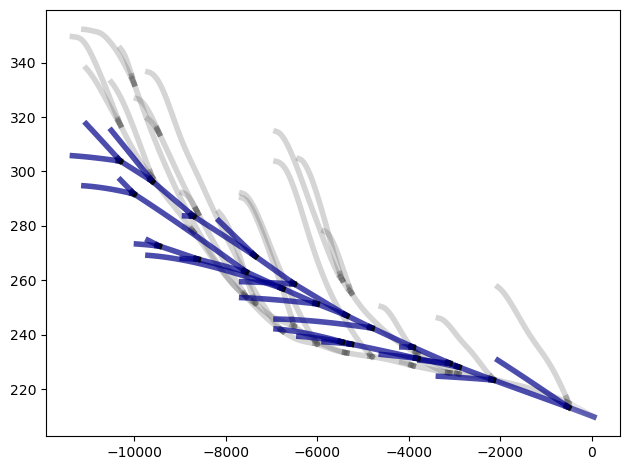

In [9]:
_dt_list = [.5, 100]
alpha_max_scalar = np.max(_dt_list)**.5 * 2

plt.figure()

_counter = 0

for _dt in _dt_list:

    net.evolve_threshold_width_river_network(nt=2, dt=_dt*3.15E7) #nt initially 100 we made this not run

    if _counter == 0:
        _color = '.3'
    else:
        # Will overwrite this in loop for variable sediment inputs
        _color = 'darkblue'
    
    _imovie = 0
    for i, lp in enumerate(segments):
        for _id in lp.downstream_segment_IDs:
            dsseg = net.list_of_LongProfile_objects[_id]
            _xjoin = [lp.x[-1], dsseg.x[0]]
            _zjoin = [lp.z[-1], dsseg.z[0]]
            plt.plot(_xjoin, _zjoin, 'k-', linewidth=4, alpha=_dt**.5/alpha_max_scalar+.2)
        if len(lp.downstream_segment_IDs) == 0:
            plt.plot(lp.x_ext[1:], lp.z_ext[1:], '-', color=_color, linewidth=4, alpha=_dt**.5/alpha_max_scalar+.1)
        else:
            plt.plot(lp.x, lp.z, '-', color=_color, linewidth=4, alpha=_dt**.5/alpha_max_scalar+.2)
    
    _counter += 1
            
plt.tight_layout()
#plt.savefig("SO_015_Q_random_mod.png")
plt.show()